# Basic Multi-agent Collaboration

하나의 에이전트는 일반적으로 단일 도메인 내에서 몇 가지 도구를 사용하여 효과적으로 작업할 수 있지만, `gpt-4`와 같은 강력한 모델을 사용하더라도 많은 도구를 사용하는 데에는 덜 효과적일 수 있습니다.

복잡한 작업에 접근하는 한 가지 방법은 "분할 정복" 접근법을 사용하는 것입니다. 즉, 각 작업이나 도메인에 대해 전문화된 에이전트를 생성하고 작업을 적절한 "전문가"에게 라우팅하는 것입니다.

이 노트북은 Wu 외 여러 저자의 논문 [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155)에서 영감을 받아 LangGraph를 사용하여 이를 구현하는 방법을 보여줍니다.

결과 그래프는 다음과 같은 다이어그램과 유사하게 보일 것입니다:

<img src="./img/simple_multi_agent_diagram.png" alt="multi_agent diagram" width="640"/>



In [1]:
!pip install -U langchain langchain_openai pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [3]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

## Agent 만들기

In [4]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Tool 정의하기


In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


# 영어로 서술하는게 많은 경우 성능이 더 좋음
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Graph 만들기

이제 도구를 정의하고 몇 가지 헬퍼 함수를 만들었으므로, 아래에서 개별 에이전트를 생성하고 이들이 LangGraph를 사용하여 서로 어떻게 소통할지 지정하겠습니다.

### State 정의하기


In [6]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Agent Nodes 정의하기

In [7]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Tool Node 정의하기

In [8]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Edge Logic 정의하기

In [9]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Graph 정의하기

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

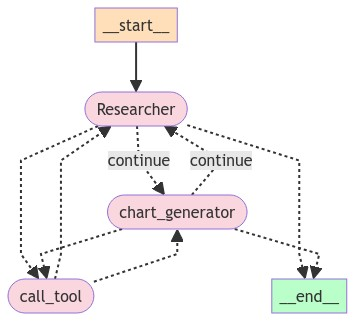

In [11]:
visualize_graph(graph)

## Invoke

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_efDR2NlcQsDGkmK9wQ7BjjYe', 'function': {'arguments': '{\n  "query": "South Korea GDP last 5 years"\n}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 217, 'total_tokens': 242}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3e7d703517', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-0244eca5-5dbf-4876-92b2-1ff127b54797-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'South Korea GDP last 5 years'}, 'id': 'call_efDR2NlcQsDGkmK9wQ7BjjYe'}], usage_metadata={'input_tokens': 217, 'output_tokens': 25, 'total_tokens': 242})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/KOR/south-korea/gdp-gross-domestic-product", "content": "South Korea gdp for 2022 wa

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8wVxZeJ3wTKUGEOxUW7ZdQP9', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for South Korea\'s GDP over the last 5 years\\nyears = [2018, 2019, 2020, 2021, 2022]\\ngdp_values = [1725.36, 1651.42, 1644.31, 1818.43, 1673.92]\\n\\n# Create a line graph\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\', linestyle=\'-\', color=\'b\')\\n\\n# Add title and labels\\nplt.title(\'South Korea GDP Over the Last 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Billion USD\')\\n\\n# Show the graph\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 186, 'prompt_tokens': 1455, 'total_tokens': 1641}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3e7d703517', 'finish_reason': 'tool_calls', 'logprobs': None}, name='chart_generator', id='run-1741a7ab-9127-

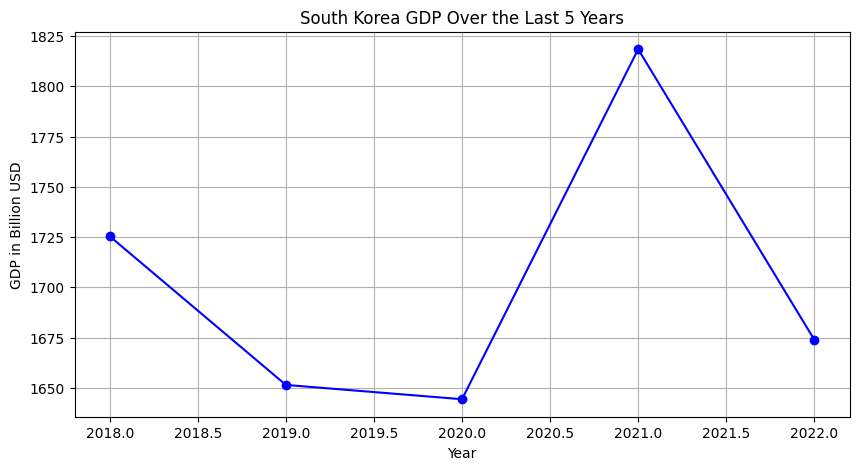

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data for South Korea's GDP over the last 5 years\nyears = [2018, 2019, 2020, 2021, 2022]\ngdp_values = [1725.36, 1651.42, 1644.31, 1818.43, 1673.92]\n\n# Create a line graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker='o', linestyle='-', color='b')\n\n# Add title and labels\nplt.title('South Korea GDP Over the Last 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion USD')\n\n# Show the graph\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_8wVxZeJ3wTKUGEOxUW7ZdQP9')]}}
----
{'chart_generator': {'messages': [AIMessage(content="Here is the line graph showing South Korea's GDP over the last 5 years:\n\n![South Korea GDP Over the Last 5 Years](sandbox:/mnt/data/chart.png)\n\nThe GDP values used in this graph are:\n\n- **2018**: $1,725.36 billion\n-

In [12]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=
                "지난 5년 동안 한국의 GDP를 가져와서, 코드를 작성해서 선그래프를 그린 후 완료하세요."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")